In [22]:
import os.path
import sys

from keras import callbacks, models
from datahandler.constants import all_features, data_version, acc_features, tensorboard_dir, location_labels
from datahandler.data_preprocessing import get_train_test_data, load_data_v3
from models.log_writer import LogWriter
from model.lstm import make_lstm_model_v1
from model.transformer import make_transformer_model_v1
from model.cnn import make_cnn_model_v1, make_cnn_model_v2
import matplotlib.pyplot as plt
from utils import print_line_divider
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from datahandler.data_preprocessing_from_jupyter import load_train_test_data_raw_normalized, load_train_test_data_added_features_normalized, load_train_test_data_added_features_pca
from audio.audio import play_training_is_complete

In [23]:
# LOGGING CONFIGURATION
enabled_log = True
enabled_tensor_board = True
log_writer = LogWriter(enabled_log)

In [24]:
# TRAINING CONFIGURATION
print("STARTING THE TRAINING PROCESS")
SAVED_BEST_MODEL = "model/best_model.h5"
window_time_in_seconds = 2
window_size = 40
epochs = 1000
batch_size = 32
validation_split = 1 / 9
optimizer = 'adam'
loss_function = "sparse_categorical_crossentropy"
supported_features = all_features

STARTING THE TRAINING PROCESS


In [25]:
log_writer.write("Configuration", line_divider=True)
log_writer.write(
    f"""Window size: {window_size}
Window time in second: ${window_time_in_seconds}
Maximum number of epochs: ${epochs}
Batch size: ${batch_size}
Validation split: ${validation_split}
Optimizer: ${optimizer}
Loss function: ${loss_function}
Features used for training: ${str(supported_features)}"""
)

In [10]:
# DATA Loader
print_line_divider()
print("Preparing data...")
# x_train, y_train, x_test, y_test = get_train_test_data(supported_features, window_time_in_seconds, window_size)
# x_train, y_train, x_test, y_test = load_data_v3(
#     features = supported_features,
#     window_time_in_seconds = window_time_in_seconds,
#     window_size = window_size
# )
x_train, y_train, x_test, y_test = load_train_test_data_added_features_normalized()
print("Train data shape: " + str(x_train.shape) + " | Train label shape: " + str(y_train.shape))
print("Test data shape: " + str(x_test.shape) + " | Test label shape: " + str(y_test.shape))
print_line_divider()


****************************************************
Preparing data...
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/px4_datacollection.csv (1/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/ps1_datacollection.csv (2/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/tc4_datacollection.csv (3/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/ss3_datacollection.csv (4/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/ps2_datacollection.csv (5/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/op4_datacollection.csv (6/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/op2_datacollection.csv (7/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_t

In [26]:
log_writer.write("Data", line_divider=True)
log_writer.write("Data loaded from version " + data_version)
log_writer.write(
    f"""Data training shape: ${x_train.shape}
Data testing shape: ${x_test.shape}"""
)

In [27]:
def check_distribution(labels_list, set_name):
    label_count_dict = {}
    for label_ind in labels_list:
        if label_ind in label_count_dict.keys():
            label_count_dict[label_ind] += 1
        else:
            label_count_dict[label_ind] = 1

    print_line_divider()
    print("Distribution for set " + set_name + "\n")
    for key in label_count_dict:
        key = int(key)
        print(location_labels[key] + " count is " + str(label_count_dict[key]))


check_distribution(y_train, "Training set")
check_distribution(y_test, "Testing set")

****************************************************
Distribution for set Training set

insidethepantpocket count is 964
beingusedinhand count is 1194
calling count is 1182
holdinginhand count is 1177
insidethebag count is 1208
****************************************************
Distribution for set Testing set

insidethepantpocket count is 230
beingusedinhand count is 304
calling count is 317
holdinginhand count is 321
insidethebag count is 299


In [28]:
if len(x_train.shape) == 2:
    input_shape = (x_train.shape[1], 1)
else:
    input_shape = x_train.shape[1:]
print("Input shape: " + str(input_shape))

Input shape: (60, 1)


In [29]:
# SETTING UP THE MODEL
# input_shape = x_train.shape[1:] # (window_size, len(supported_features))
model_name, model = make_cnn_model_v1(input_shape=input_shape)
# model_name, model = make_lstm_model_v1(input_shape=input_shape)
# model_name, model = make_transformer_model_v1(
#     input_shape=input_shape,
#     head_size=256,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=2,
#     mlp_units=[128],
#     mlp_dropout=0.4,
#     dropout=0.25,
# )
print("Model Summary:")
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)
print(print_line_divider())

Model Summary:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 64)            256       
                                                                 
 batch_normalization_3 (Batc  (None, 60, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 60, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 60, 64)            12352     
                                                                 
 batch_normalization_4 (Batc  (None, 60, 64)           256       
 hNormalization)                            

In [30]:
# LOGGING THE MODEL
log_writer.write("Model", line_divider=True)
log_writer.write("Model name: " + model_name)
log_writer.write(short_model_summary)

In [31]:
# MODELS CALLBACK AND SETUP
callback_list = [
    callbacks.ModelCheckpoint(SAVED_BEST_MODEL, save_best_only=True, monitor="val_loss"),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=50, min_lr=0.0001),
    callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1)
]
if enabled_tensor_board:
    callback_list.append(callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1))
if log_writer.enabled:
    callback_list.append(
        callbacks.ModelCheckpoint(log_writer.base_folder + "/model.h5", save_best_only=True, monitor="val_loss")
    )
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=["sparse_categorical_accuracy"],
)

In [32]:
# TRAINING
print_line_divider()
print("Starting to train...")
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callback_list,
    validation_split=validation_split,
    verbose=1,
    shuffle=True
)
print("Highest validation accuracy: ", max(history.history['val_sparse_categorical_accuracy']))
log_writer.write("Result", line_divider=True)
log_writer.write("Highest validation accuracy: " + str(max(history.history['val_sparse_categorical_accuracy'])))
play_training_is_complete()

****************************************************
Starting to train...
Epoch 1/1000
159/159 [==============================] - 3s 15ms/step - loss: 1.3079 - sparse_categorical_accuracy: 0.5083 - val_loss: 2.0193 - val_sparse_categorical_accuracy: 0.3736 - lr: 0.0010
Epoch 2/1000
159/159 [==============================] - 2s 14ms/step - loss: 1.0125 - sparse_categorical_accuracy: 0.6720 - val_loss: 2.5396 - val_sparse_categorical_accuracy: 0.3736 - lr: 0.0010
Epoch 3/1000
159/159 [==============================] - 2s 16ms/step - loss: 0.8272 - sparse_categorical_accuracy: 0.7402 - val_loss: 2.9835 - val_sparse_categorical_accuracy: 0.3736 - lr: 0.0010
Epoch 4/1000
159/159 [==============================] - 3s 17ms/step - loss: 0.7022 - sparse_categorical_accuracy: 0.7809 - val_loss: 2.8260 - val_sparse_categorical_accuracy: 0.0816 - lr: 0.0010
Epoch 5/1000
159/159 [==============================] - 3s 16ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.8076 - val_loss: 2.5311 -

Input #0, wav, from '/var/folders/ph/8yv0q18n4mb1439tnf3rzcf40000gp/T/tmpwxb_3em5.wav':
  Duration: 00:00:02.27, bitrate: 705 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s16, 705 kb/s


In [33]:
if log_writer.enabled:
    model.save(log_writer.base_folder + "/model_last.h5")

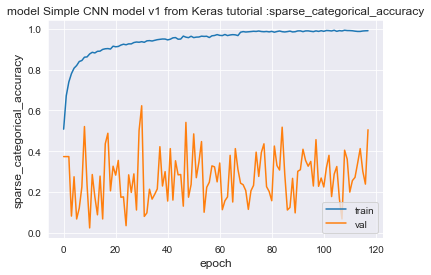

In [34]:
# PLOTTING
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + model_name + " :" + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Validation progress.png"))
plt.show()
plt.close()

46/46 [==============================] - 0s 5ms/step - loss: 1.0786 - sparse_categorical_accuracy: 0.6241
****************************************************
Test accuracy 0.6240652799606323
Test loss 1.0785962343215942


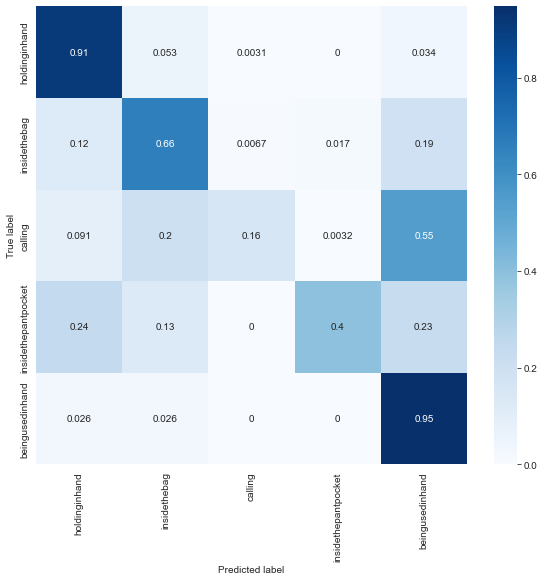

In [35]:
# EVALUATION
model = models.load_model(SAVED_BEST_MODEL)

test_loss, test_acc = model.evaluate(x_test, y_test)
print_line_divider()
print("Test accuracy", test_acc)
print("Test loss", test_loss)

# Accuracy based on different labels
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)
con_mat_df = pd.DataFrame(con_mat_norm, index=location_labels, columns=location_labels)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Accuracy.png"))
plt.show()
plt.close()

log_writer.write("Test evaluation", line_divider=True)
log_writer.write("Test accuracy: " + str(test_acc))
log_writer.write("Test loss: " + str(test_loss))
log_writer.close()